In [22]:
from pathlib import Path
import json
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [23]:
log_dict = {
    'Ditto-ALBERT':'/mnt/16t_3/jiyuwen/benchmark/baseline_ditto/logdir_ditto_albert',
    'Ditto-BERT':'/mnt/16t_3/jiyuwen/benchmark/baseline_ditto/logdir_ditto_bert',
    'Ditto-DistilBERT':'/mnt/16t_3/jiyuwen/benchmark/baseline_ditto/logdir_ditto_distilbert',
    'Ditto-RoBERTa':'/mnt/16t_3/jiyuwen/benchmark/baseline_ditto/logdir_ditto_roberta',
    'DeepMatcher':'/mnt/16t_3/jiyuwen/benchmark/baseline_deepmatcher/logdir',
    'SpaBERT':'/mnt/16t_3/jiyuwen/benchmark/baseline_spabert/logdir_base',
    'GeoLM':'/mnt/16t_3/jiyuwen/benchmark/baseline_spabert/logdir_geolm',
    'GeoVectors':'/mnt/16t_3/jiyuwen/benchmark/baseline_geovectors/logdir',
}


In [24]:
baseline_log = {}
for k,v in log_dict.items():
    baseline_log.setdefault(k,{})
    for p in Path(v).rglob('*.log'):
        baseline_log[k].setdefault(p.stem,{})
        baseline_log[k][p.stem][p.parent.stem]=(0.0,None)
        with p.open('r') as f:
            for line in f.readlines():
                res = json.loads(line.strip())
                if 'Test_f1' in res:
                    res = res['Test_f1']
                elif 'Test_F1' in res:
                    res = res['Test_F1']
                elif 'Last_f1' in res:
                    res = res['Last_f1']
                else:
                    print(res)
                    raise
                avg,std = re.findall(r'\d+\.\d+|\d+', res)
                avg,std = float(avg),float(std)
                if baseline_log[k][p.stem][p.parent.stem][0]<avg:
                    baseline_log[k][p.stem][p.parent.stem]=(avg,std)

In [25]:
main_log_path = '/home/jiyuwen/project/gs_geo_er/log_dir'
k = 'GeoER'
baseline_log.setdefault(k,{})
for p in Path(main_log_path).rglob('*.log'):
    baseline_log[k].setdefault(p.stem,{})
    prob = p.parent.stem.split('_')[-1]
    baseline_log[k][p.stem][prob]=(0.0,None)
    with p.open('r') as f:
        for line in f.readlines():
            if line.startswith('0'):
                start = line.index('{')
                res = json.loads(line.strip()[start:])['Test_F1']
                avg,std = re.findall(r'\d+\.\d+|\d+', res)
                avg,std = float(avg),float(std)
                if baseline_log[k][p.stem][prob][0]<avg:
                    baseline_log[k][p.stem][prob]=(avg,std)

In [26]:
main_log_path = '/home/jiyuwen/project/gs_geo_er/log_dir'
k = 'Ours'
baseline_log.setdefault(k,{})
for p in Path(main_log_path).rglob('*.log'):
    if '_ablation' in str(p):
        continue
    baseline_log[k].setdefault(p.stem,{})
    prob = p.parent.stem.split('_')[-1]
    baseline_log[k][p.stem][prob]=(0.0,None)
    with p.open('r') as f:
        for line in f.readlines():
            if line.startswith('2'):
                start = line.index('{')
                res = json.loads(line.strip()[start:])['Test_F1']
                avg,std = re.findall(r'\d+\.\d+|\d+', res)
                avg,std = float(avg),float(std)
                if baseline_log[k][p.stem][prob][0]<avg:
                    baseline_log[k][p.stem][prob]=(avg,std)

In [27]:
baseline_log['Ours']['osm_fsq_sin']

{'0d4': (0.728, 0.009),
 '0d2': (0.797, 0.01),
 '0d0': (0.889, 0.001),
 '1d0': (0.621, 0.005),
 '0d8': (0.634, 0.011),
 '0d6': (0.688, 0.013)}

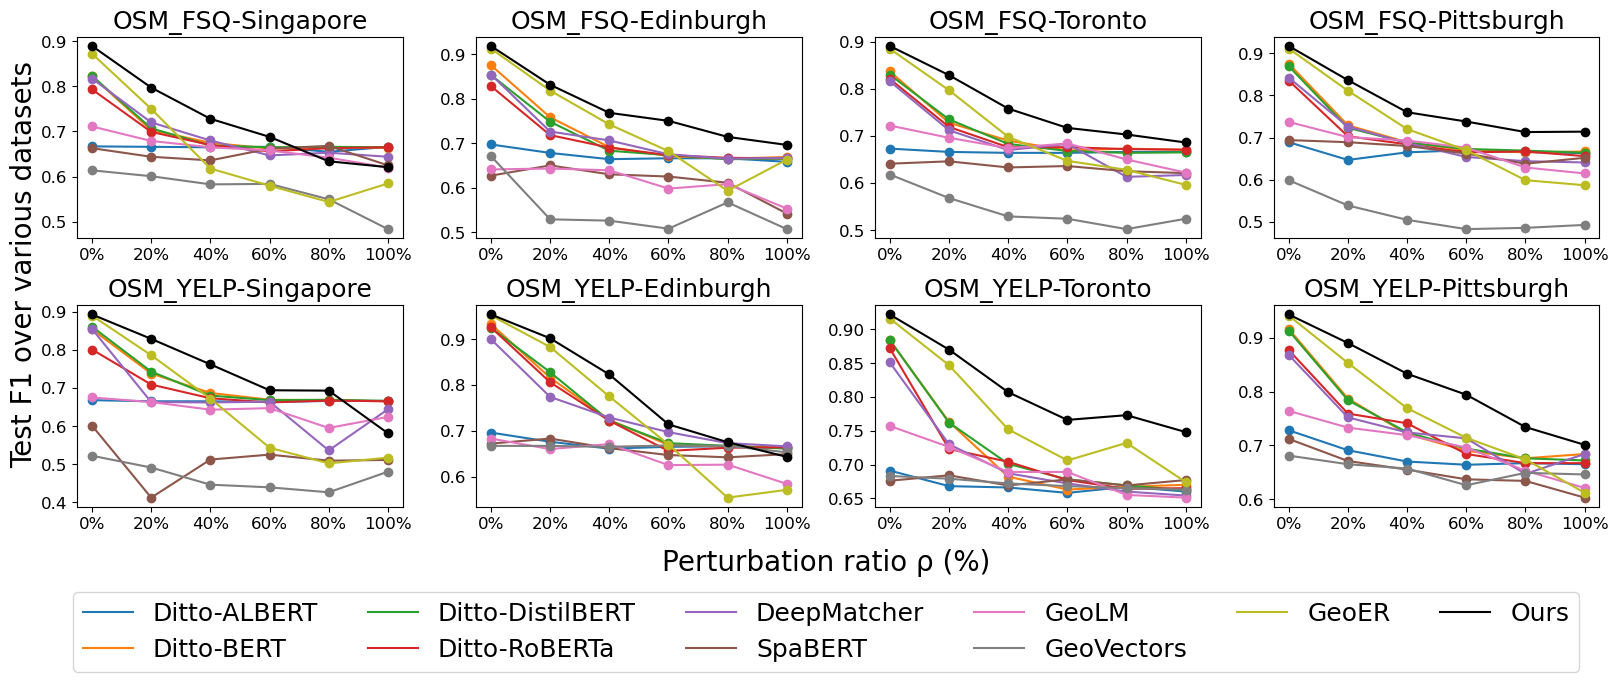

In [28]:
fig, axs = plt.subplots(2, 4, figsize=(16, 6))
citys = ['sin','edi','tor','pit']
citys_map = ['Singapore','Edinburgh','Toronto','Pittsburgh']
sources = ['osm_fsq','osm_yelp']
sorted_keys = ['0d0', '0d2', '0d4', '0d6', '0d8', '1d0']
x_values = [f"{int(float(key.replace('d','.'))*100)}%" for key in sorted_keys]
random_colors = [mcolors.to_hex(c) for c in mcolors.TABLEAU_COLORS]
lines = []
labels = []
for ind,(k,v) in enumerate(baseline_log.items()):
    for name,data in v.items():
        if len(data)!=6:
            continue
        src,city = name.rsplit('_',1)
        ax = axs[sources.index(src)][citys.index(city)]
        y_values = [data[key][0] for key in sorted_keys]
        if k == 'Ours':
            ax.plot(x_values, y_values, color='black', marker='o',label=k)
        else:
            ax.plot(x_values, y_values, color=random_colors[ind], marker='o',label=k)  
        ax.set_title(f'{src.upper()}-{citys_map[citys.index(city)]}',fontsize=18)
        ax.tick_params(labelsize=12)
    if k == 'Ours':
        lines.append(ax.plot([], [], color='black')[0])
    else:
        lines.append(ax.plot([], [])[0])
    labels.append(k)
fig.text(0.5, -0.01, 'Perturbation ratio ρ (%)', ha='center',fontsize=20)
fig.text(-0.01, 0.5, 'Test F1 over various datasets', va='center',fontsize=20, rotation='vertical') 
fig.legend(lines, labels, loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.2),fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.tight_layout()
plt.show()